In [1]:
import energyplus.ooep as ooep
import energyplus.ooep.ems
import energyplus.ooep.addons.state

from energyplus.dataset.basic import dataset as epds

env = energyplus.ooep.ems.Environment().__enter__()

keys = ['CHILLER', 'CHILLER 1', 'CHILLER 2']
emeter = [env.variable(dict(variable_name='Chiller Electricity Rate', variable_key=key)) for key in keys]

T_outdoor = env.variable(dict(
    variable_name='Site Outdoor Air Drybulb Temperature',
    variable_key='ENVIRONMENT'
))

F_chw = env.variable(dict(variable_name='System Node Mass Flow Rate', variable_key='CHW Loop Supply Side'))
T_chws = env.variable(dict(variable_name='Chiller Evaporator Outlet Temperature', variable_key='Chiller'))
T_chwr = env.variable(dict(variable_name='Chiller Evaporator Inlet Temperature', variable_key='Chiller'))

T_chws_set = env.actuator(dict(component_type='System Node Setpoint',control_type = 'Temperature Setpoint', actuator_key='CHW Loop Supply Side Outlet'))


sm_env = ooep.addons.state.StateMachine(env)
sm_stepf = sm_env.step_function(
    dict(event_name='begin_zone_timestep_after_init_heat_balance')
)

sm_env.run(
    '--output-directory', 'build2/demo-eplus',
    '--weather', f'./USA_FL_Tampa.Intl.AP.722110_TMY3.epw',
    f'./new1ch.idf',
    verbose=True,
)
print('output', 'build2/demo-eplus',  file=__import__('sys').stderr)

output build2/demo-eplus


In [2]:
def calculate_cooling_load(T_chwr, T_chws, C_p=4200, rho=1000):
    return (C_p * rho * (T_chwr - T_chws)) / 3600

def calculate_reward(T_chwr, x_comfort, x_energy,  P_chiller, P_chiller_nominal=60000, beta1=0.25, beta2=4.15, beta3=-1, beta4=1):
    U_comfort = 1 / (1 + beta1 * np.exp(beta2 * (T_chwr - 6)))
    U_energy =  beta3 * ((np.sum(P_chiller))/P_chiller_nominal) + beta4
    return U_comfort * x_comfort + U_energy * x_energy


In [14]:
import numpy as np

# Define Q-learning parameters
alpha = 0.1  # Learning rate
gamma = 0.99  # Discount factor
epsilon = 0.1  # Exploration rate

# Define state and action spaces
num_actions = 3  # Increase, remain same, decrease
num_states = 100  # Number of discrete states

# Initialize Q-table
Q = np.zeros((num_states, num_actions))

# Define state discretization parameters
min_cooling_load = 0
max_cooling_load = 1000
min_outdoor_temp = -10
max_outdoor_temp = 40

# Define function to discretize state
def discretize_state(cooling_load, outdoor_temp):
    cooling_load = np.clip(cooling_load, min_cooling_load, max_cooling_load)
    outdoor_temp = np.clip(outdoor_temp, min_outdoor_temp, max_outdoor_temp)
    cooling_load_scaled = (cooling_load - min_cooling_load) / (max_cooling_load - min_cooling_load)
    outdoor_temp_scaled = (outdoor_temp - min_outdoor_temp) / (max_outdoor_temp - min_outdoor_temp)
    state = int(cooling_load_scaled * (num_states - 1))
    return state

# Define function to select action using epsilon-greedy policy
def select_action(state):
    if np.random.rand() < epsilon:
        action = np.random.choice(num_actions)   # Exploration
        action_mapping = {
        0: -1,  # Decrease setpoint temperature by 1 degree
        1: 0,   # Maintain current setpoint temperature
        2: 1    # Increase setpoint temperature by 1 degree
        }

        # Update Setpoint Temperature based on Chosen Action
        delta_setpoint = action_mapping[action]
        new_setpoint = T_chws_set.value + delta_setpoint
        T_chws_set.value = new_setpoint
        return action  # Exploration
    else:
        action = np.argmax(Q[state])  # Exploitation
        action_mapping = {
        0: -1,  # Decrease setpoint temperature by 1 degree
        1: 0,   # Maintain current setpoint temperature
        2: 1    # Increase setpoint temperature by 1 degree
        }

        # Update Setpoint Temperature based on Chosen Action
        delta_setpoint = action_mapping[action]
        new_setpoint = T_chws_set.value + delta_setpoint
        T_chws_set.value = new_setpoint
        return action

# Define function to update Q-table
def update_Q_table(state, action, reward, next_state):
    best_next_action = np.argmax(Q[next_state])
    Q[state, action] += alpha * (reward + gamma * Q[next_state, best_next_action] - Q[state, action])


import matplotlib.pyplot as plt

# Define variables to store training metrics
total_rewards = []


# Training Loop
while True:
    # Reset environment
    # Perform necessary initialization here
    
    total_reward = 0
    try: 
        # Get current state
        cooling_load = calculate_cooling_load(T_chwr.value, T_chws.value)
        outdoor_temp = T_outdoor.value
        state = discretize_state(cooling_load, outdoor_temp)
        
        # Select action
        action = select_action(state)
        
        # Take action and observe next state and reward
        # Perform action in the environment and get next state, reward, and done flag
        reward = calculate_reward(T_chwr.value, 0.5, 0.5 , emeter[0].value + emeter[1].value + emeter[2].value )
        
        # Get next state
        sm_stepf()
        next_cooling_load = calculate_cooling_load(T_chwr.value, T_chws.value)
        next_state = discretize_state(next_cooling_load, T_outdoor.value)

        # Update Q-table
        update_Q_table(state, action, reward, next_state)
        
        # Update variables for next iteration
        state = next_state
        total_reward += reward
        total_rewards.append(total_reward)
    
        # Print episode stats
        print(f"emeter={emeter[0].value,emeter[1].value,emeter[2].value}) (T_outdoor={T_outdoor.value}) (F_chw={F_chw.value}) (T_chws={T_chws.value}) (T_chwr={T_chwr.value}) (T_chws_set={T_chws_set.value} Total Reward = {total_reward}")

    except ooep.ems.NotReadyError: pass
    

# Testing and Evaluation
# Run the trained agent in the simulation environment and collect performance metrics

# Results Analysis
# Analyze the performance of the Q-learning-based controller


emeter=(70700.06268730504, 0.0, 36524.00587030807)) (T_outdoor=27.25) (F_chw=0.0) (T_chws=6.0) (T_chwr=12.843091762377876) (T_chws_set=5.0 Total Reward = -0.3935339046458478
emeter=(70519.37871952534, 0.0, 36162.63793474864)) (T_outdoor=27.066666666666663) (F_chw=0.0) (T_chws=6.0) (T_chwr=12.874666126882545) (T_chws_set=6.0 Total Reward = -0.3935339046458478
emeter=(70519.37871952534, 0.0, 36162.63793474864)) (T_outdoor=27.066666666666663) (F_chw=0.0) (T_chws=6.0) (T_chwr=12.874666126882545) (T_chws_set=7.0 Total Reward = -0.38901680545146916
emeter=(70501.70666323144, 0.0, 36127.29382216083)) (T_outdoor=26.883333333333333) (F_chw=0.0) (T_chws=6.0) (T_chwr=12.909870715469452) (T_chws_set=6.0 Total Reward = -0.3839893021792916
emeter=(70501.70666323144, 0.0, 36127.29382216083)) (T_outdoor=26.883333333333333) (F_chw=0.0) (T_chws=6.0) (T_chwr=12.909870715469452) (T_chws_set=6.0 Total Reward = -0.38857500404423206
emeter=(69969.6269630781, 0.0, 35063.13442185416)) (T_outdoor=26.7) (F_chw=0

KeyboardInterrupt: 

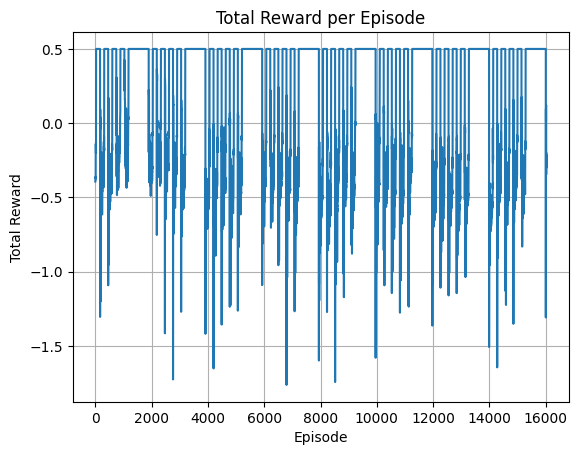

In [15]:
plt.plot(total_rewards)
plt.xlabel('Episode')
plt.ylabel('Total Reward')
plt.title('Total Reward per Episode')
plt.grid(True)
plt.show()